In [42]:
disable_warnings = True
if disable_warnings:
    import warnings
    warnings.filterwarnings('ignore')

import json
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from utils.model_utils import ExtendedLanguageModel
from utils.data_utils import AnalogiesDataLoader
from utils.plot_utils import plot_RDM_concept
from utils.eval_utils import get_RDM, get_unique_indices, get_rule_sim_diagonal

from __future__ import print_function
from ipywidgets import interactive


DATA_DIR = 'data/analogies'
COMPLETION_DIR = 'data/completions'
INTERNALS_DIR = 'data/internals'

In [43]:
# Select Model
model_widget = interactive(lambda model_name: model_name,
                      model_name=[
                            'meta-llama/Llama-2-70b-hf',
                            'EleutherAI/gpt-j-6b'
                      ])
display(model_widget)

dataset = 'analogies_prowise_ENG'
analogies_df = pd.read_csv(f'{DATA_DIR}/analogies_prowise_ENG.csv')

interactive(children=(Dropdown(description='model_name', options=('meta-llama/Llama-2-70b-hf', 'EleutherAI/gpt…

In [140]:
# Load Model
model_name = model_widget.children[0].value
model = ExtendedLanguageModel(model_name)
print(f"Selected model: {model_name}\n")
prompts, mc_to_opt, indices = AnalogiesDataLoader(dataset)[0]
print(prompts[100])

Selected model: meta-llama/Llama-2-70b-hf

### Instruction: man is to king as woman is to
(a) girl
(b) child
(c) queen
(d) cat
(e) crown
### Response: (c)
### Instruction: peach is to fruit, as hospital is to
(a) food
(b) building
(c) sick
(d) nice
(e) doctor
### Response: (


In [141]:
# Load Completions
raw_data = json.load(open(f'{COMPLETION_DIR}/{dataset}__{model.nickname}.json'))
completion_df = pd.DataFrame.from_dict(raw_data, orient='index')[['Ans1', 'Ans2', 'Ans3', 'Ans4', 'D', 'completion_token', 'completion_prob']]
completion_df['correct'] = completion_df.apply(lambda row: 1 if row['D'] > max(row['Ans1'], row['Ans2'], row['Ans3']) else 0, axis=1)
completion_df['prob_diff'] = completion_df.apply(lambda row: abs(row['D'] - max(row['Ans1'], row['Ans2'], row['Ans3'])), axis=1)

completion_df['type_relation'] = analogies_df['type_relation'].values
completion_df['type_relation_jones'] = analogies_df['type_relation_jones'].values
completion_df.index = completion_df.index.astype(int)

print(f'Accuracy: {completion_df.correct.mean().round(2)}')
completion_df.head()

Accuracy: 0.72


,Ans1,Ans2,Ans3,Ans4,D,completion_token,completion_prob,correct,prob_diff,type_relation,type_relation_jones
0,0.272339,0.148787,0.461235,0.034084,0.082185,e,0.461235,0,0.379050,actie-resultaat,causal
1,0.273429,0.052744,0.099916,0.012933,0.559456,d,0.559456,1,0.286027,actie-resultaat,causal
2,0.231744,0.065603,0.037187,0.032194,0.631941,e,0.631941,1,0.400196,actie-resultaat,causal
3,0.943944,0.014210,0.007124,0.019473,0.011962,e,0.943944,0,0.931982,actie-resultaat,causal
4,0.843260,0.010243,0.007962,0.023177,0.112954,e,0.843260,0,0.730306,actie-resultaat,causal


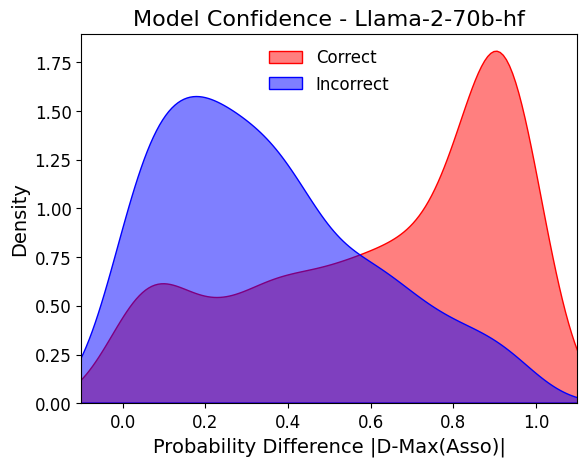

In [142]:
# Plot Model Confidence
plt.figure()

sns.kdeplot(completion_df[completion_df['correct'] == 1]['prob_diff'], label='Correct', color='red', fill=True, alpha=0.5)
sns.kdeplot(completion_df[completion_df['correct'] == 0]['prob_diff'], label='Incorrect', color='blue', fill=True, alpha=0.5)

plt.xlabel('Probability Difference |D-Max(Asso)|', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, frameon=False, loc='upper center')
plt.title(f'Model Confidence - {model.nickname}', fontsize=16)
plt.xlim(-0.1, 1.1)

plt.show()

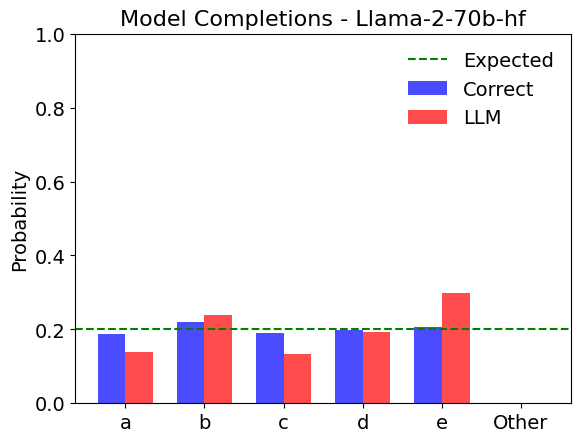

In [143]:
# Plot Completion Tokens

# count the number of times each completion token was used
count_dict = {key: 0 for key in list(mc_to_opt[0].keys())+['Other']}
for entry in mc_to_opt:
    for key, value in entry.items():
        if value == 'D':
            count_dict[key] += 1

# count the number of times each completion token was chosen
completion_df['completion_token'].value_counts().sort_index().to_dict()

llm = {'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'other': 0}
for key, value in completion_df['completion_token'].value_counts().sort_index().to_dict().items():
    if key in llm.keys():
        llm[key] = value
    else:
        llm['other'] += value

responses = list(count_dict.keys())
org = list(count_dict.values()) 
org_prop = org / np.sum(org)
llm = list(llm.values())
llm_prop = llm / np.sum(llm)

# Setting the position of bars on the x-axis
bar_width = 0.35
index = np.arange(len(responses))

# Plotting the bar plot
plt.figure()

bar1 = plt.bar(index, org_prop, bar_width, label='Correct', color='b', alpha=0.7)
bar2 = plt.bar(index + bar_width, llm_prop, bar_width, label='LLM', color='r', alpha=0.7)

# expected value
plt.axhline(y=1/5, color='g', linestyle='--', label='Expected')

plt.ylabel('Probability', fontsize=14)
plt.title(f'Model Completions - {model.nickname}', fontsize=16)
plt.xticks(index + bar_width / 2, responses, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 1)
plt.legend(fontsize=14, frameon=False)
plt.show()

1. Do the same analysis with Function Vector data - get the function vector per item for different functions
    
    - If we don't see clusters -> 
        - Implementation is not correct
        - Per item function vector is not worth much - it only gets its effect when averaging over the multiple activations of the att heads
            * The FV is the "ideal" function representation. Compute per item similarity with this ideal vector
    
    - If we do see clusters ->
        - Check if the clusters and FV work with 1 training example (in the paper they used 10 examples)
            - If no clusters with 1 training example:
                * The "ideal" FV is formed after seeing many training examples. Compute per item similarity with this ideal vector
            
            - If there are clusters with 1 training example:
                * The experimental design is too different Input:Output Input:Output Input:? Vs Our multiple choice prompt
                * The attention heads found by previous paper don't generalize to our analogies 

2. The dataset is the problem
    - With the ConceptNet dataset we saw clustering within relations at the final embeddings in GPT-2, but not in the Prowise dataset
        * The task presentation was still different - A is to B as C is to D -> capture embeddings at D        

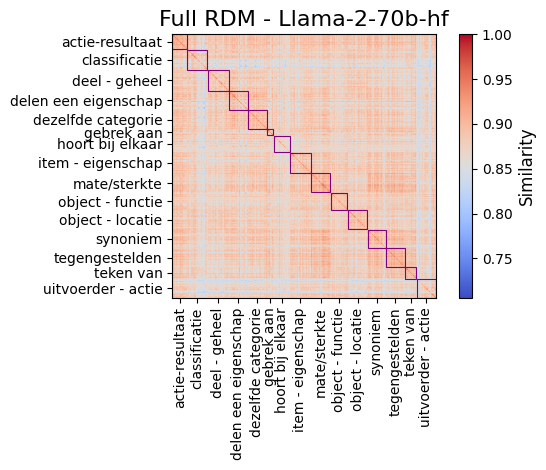

In [144]:
# Plot Full RDM
vecs = np.load(f'{INTERNALS_DIR}/{dataset}__{model.nickname}.npy')

# Remove relations with less than 20 samples
rel_n = completion_df.groupby('type_relation')['type_relation'].count().reset_index(name='count')
rels_to_remove = rel_n[rel_n['count']<20]['type_relation'].values
completion_df_filter = completion_df[~completion_df['type_relation'].isin(rels_to_remove)].reset_index(drop=True)
vecs_filter = vecs[~completion_df['type_relation'].isin(rels_to_remove)]

# Sort by type_relation
relation = 'type_relation'
completion_df_sorted = completion_df_filter.sort_values(by=relation)
sort_idx = completion_df_sorted.index
vecs_sorted = vecs_filter[sort_idx]

# Get relation indices
full_rel_idx = get_unique_indices(completion_df_sorted[relation])

full_rdm = get_RDM(vecs_sorted)

plot_RDM_concept(full_rdm, full_rel_idx, title=f'Full RDM - {model.nickname}', rel_ticks=True)

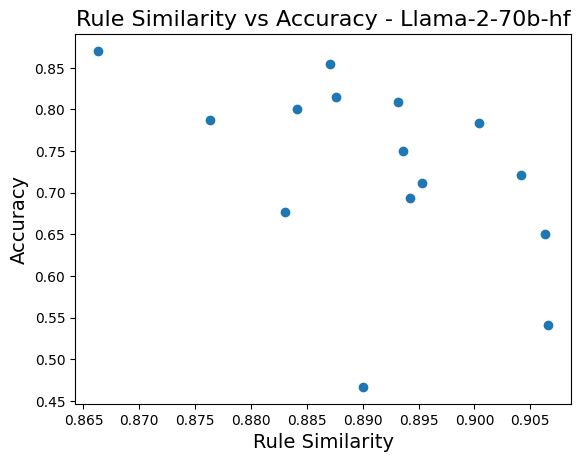

In [145]:
sim = get_rule_sim_diagonal(1-full_rdm, full_rel_idx, sort=False)['Similarity']
acc = completion_df_sorted.groupby('type_relation')['correct'].mean().values

plt.figure()
plt.scatter(sim, acc)
plt.xlabel('Rule Similarity', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title(f'Rule Similarity vs Accuracy - {model.nickname}', fontsize=16)
plt.show()

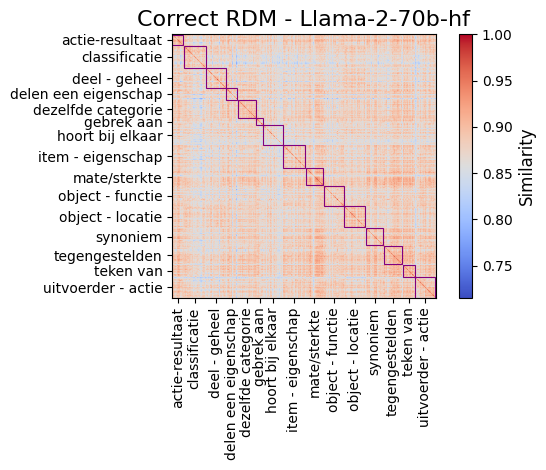

In [146]:
# Correct RDM
completion_df_sorted_correct = completion_df_sorted[completion_df_sorted['correct'] == 1]
sort_idx_correct = completion_df_sorted_correct.index
vecs_sorted_correct = vecs[sort_idx_correct]

# Get relation indices
correct_rel_idx = get_unique_indices(completion_df_sorted_correct[relation])

correct_rdm = get_RDM(vecs_sorted_correct)

plot_RDM_concept(correct_rdm, correct_rel_idx, title=f'Correct RDM - {model.nickname}', rel_ticks=True)

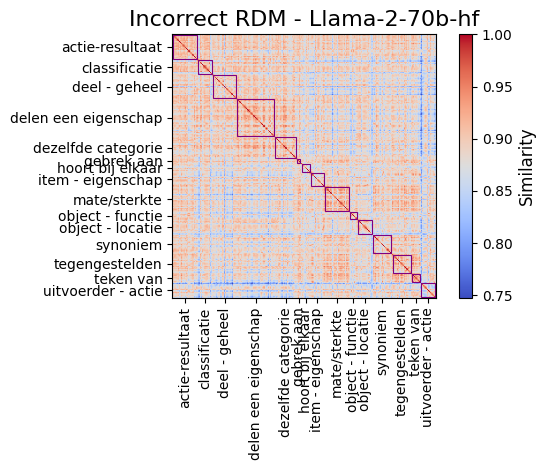

In [147]:
# Incorrect RDM
completion_df_sorted_incorrect = completion_df_sorted[completion_df_sorted['correct'] == 0]
sort_idx_incorrect = completion_df_sorted_incorrect.index
vecs_sorted_incorrect = vecs[sort_idx_incorrect]

# Get relation indices
incorrect_rel_idx = get_unique_indices(completion_df_sorted_incorrect[relation])

incorrect_rdm = get_RDM(vecs_sorted_incorrect)

plot_RDM_concept(incorrect_rdm, incorrect_rel_idx, title=f'Incorrect RDM - {model.nickname}', rel_ticks=True)

In [148]:
get_rule_sim_diagonal(1-full_rdm, full_rel_idx)

,Concept,Similarity
0,actie-resultaat,0.906631
8,mate/sterkte,0.906315
12,tegengestelden,0.904185
13,teken van,0.900407
11,synoniem,0.895275
4,dezelfde categorie,0.894241
5,gebrek aan,0.893610
10,object - locatie,0.893167
3,delen een eigenschap,0.890033
7,item - eigenschap,0.887651


In [149]:
completion_df_sorted.groupby('type_relation')['correct'].mean().sort_values(ascending=False)

type_relation
hoort bij elkaar        0.870370
object - functie        0.854545
item - eigenschap       0.815385
object - locatie        0.809524
classificatie           0.800000
uitvoerder - actie      0.786885
teken van               0.783784
gebrek aan              0.750000
tegengestelden          0.721311
synoniem                0.711864
dezelfde categorie      0.693548
deel - geheel           0.676471
mate/sterkte            0.650794
actie-resultaat         0.541667
delen een eigenschap    0.466667
Name: correct, dtype: float64

In [150]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# k-Means Clustering
kmeans = KMeans(n_clusters=len(np.unique(full_rel_idx.keys())))
labels = kmeans.fit_predict(vecs_sorted)

labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [151]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(vecs)

Text(0, 0.5, 't-SNE 2')

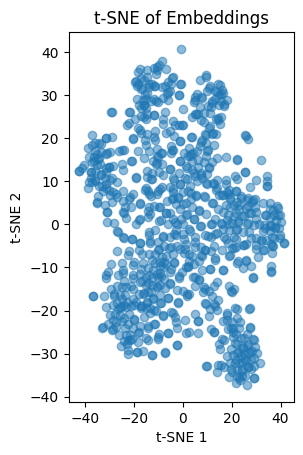

In [152]:
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], cmap='viridis', alpha=0.5)
plt.title('t-SNE of Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')